In [1]:
import os

import numpy as np
from sklearn.manifold import TSNE
import pandas as pd

import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

----

In [28]:
# params
log_dir = "/logfiles"
model = "bigscience-T0_3B" # bigscience-T0_B or bigscience-T0
module = "encoder" # encoder or decoder
tasks = ["rte", "wic"]

## Prompts

In [38]:
task_dfs = {}
for task in tasks:
    df = read_templates_from_file(f"/t0-analysis/prompts/{task}/all.csv")
    # df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_prompt.csv")
    # df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_target_yes_no.csv")
    task_dfs[task] = df
    print(task)
    display(df)

rte


,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_yes_no_with_targets,{premise} Question: {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No","0, 1",False
1,mnli_crowdsource_with_targets,{premise} Using only the above description and...,instructive,True,"▁Yes, ▁No","0, 1",False
2,based_on_previous_passage_with_targets,"{premise} Based on the previous passage, is it...",instructive,True,"▁Yes, ▁No","0, 1",False
3,infer_with_targets,"Suppose {premise} Can we infer that ""{hypothes...",instructive,True,"▁Yes, ▁No","0, 1",False
4,follow_with_targets,Given that {premise} Does it follow that {hypo...,instructive,True,"▁Yes, ▁No","0, 1",False
5,imply_with_targets,"{premise} Question: Does this imply that ""{hyp...",instructive,True,"▁Yes, ▁No","0, 1",False
6,guaranteed_with_targets,"Given {premise} Is it guaranteed true that ""{h...",instructive,True,"▁Yes, ▁No","0, 1",False
7,justified_with_targets,"{premise} Are we justified in saying that ""{hy...",instructive,True,"▁Yes, ▁No","0, 1",False
8,must_be_true_with_targets,"Given that {premise} Therefore, it must be tru...",instructive,True,"▁Yes, ▁No","0, 1",False
9,should_assume_with_targets,"Given {premise} Should we assume that ""{hypoth...",instructive,True,"▁Yes, ▁No","0, 1",False


wic


,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_without_targets,{sentence1} {sentence2} Question: Is the word ...,instructive,False,"▁No, ▁no, ▁Yes, ▁yes","0, 0, 1, 1",False
1,gpt_3_yes_no_with_targets,{sentence1} {sentence2} Question: Is the word ...,instructive,True,"▁No, ▁Yes","0, 1",False
2,affirmation_with_targets,Sentence A: {sentence1} Sentence B: {sentence2...,instructive,True,"▁Fal, ▁True","0, 1",False
3,grammar_homework_with_targets,"Decide whether the word ""{word}"" is used with ...",instructive,True,"▁No, ▁Yes","0, 1",False
4,polysemous_with_targets,"The word ""{word}"" has multiple meanings. Does ...",instructive,True,"▁No, ▁Yes","0, 1",False
5,question_context_without_targets,"Determine if the word ""{word}"" is used in the ...",instructive,False,"▁No, ▁no, ▁Yes, ▁yes","0, 0, 1, 1",False
6,question_meaning_without_targets,"Determine if the word ""{word}"" have the same m...",instructive,False,"▁No, ▁no, ▁Yes, ▁yes","0, 0, 1, 1",False
7,question_meaning_yes_no_with_targets,"Does the word ""{word}"" have the same meanining...",instructive,True,"▁No, ▁Yes","0, 1",False
8,same_sense_with_targets,Sentence 1: {sentence1} Sentence 2: {sentence2...,instructive,True,"▁No, ▁Yes","0, 1",False
9,similar_sense_without_targets,{sentence1} {sentence2} Similar sense of {word}?,instructive,False,"▁No, ▁no, ▁Yes, ▁yes","0, 0, 1, 1",False


In [74]:
# load prompted inputs and labels
input_dfs = {}
for task in tasks:
    df_inputs = {}
    for _, row in task_dfs[task].iterrows():
        prompt = row['name']
        df_inputs[prompt] = pd.read_csv(f"/logfiles/{task}/{model}/{module}/{prompt}/prompted_samples.csv", sep='\t', index_col=0)
    input_dfs[task] = df_inputs


In [75]:
input_dfs['rte']['gpt_3_yes_no_with_targets'].head()

,input,label,prediction
0,"Dana Reeve, the widow of the actor Christopher...",not_entailment,not_entailment
1,"Yet, we now are discovering that antibiotics a...",entailment,not_entailment
2,Cairo is now home to some 15 million people - ...,not_entailment,not_entailment
3,"The Amish community in Pennsylvania, which num...",not_entailment,not_entailment
4,Security forces were on high alert after an el...,entailment,not_entailment


In [76]:
# load decoded predictions
output_dfs = {}
for task in tasks:
    df_outputs = {}
    for _, row in task_dfs[task].iterrows():
        prompt = row['name']
        df_outputs[prompt] = pd.read_csv(f"/logfiles/{task}/{model}/{module}/{prompt}/decoded_predictions.csv", sep='\t', names=['predicitons'])
    output_dfs[task] = df_outputs

In [77]:
output_dfs['rte']['gpt_3_yes_no_with_targets'].head()

,predicitons
0,"['<pad>', '▁No', '</s>']"
1,"['<pad>', '▁No', '</s>']"
2,"['<pad>', '▁No', '</s>']"
3,"['<pad>', '▁No', '</s>']"
4,"['<pad>', '▁No', '</s>']"


## Plot t-SNE embeddings

In [78]:
use_patterns = {}
for task in tasks:
    if task == 'rte':
        use_patterns[task] = [
            "gpt_3_yes_no_with_targets",
            "gpt_3_true_false_with_targets",
            "gpt_3_cat_dog_with_targets",
            # "gpt_3_yes_no_without_targets",
            # "mnli_crowdsource_with_targets",
            # "based_on_previous_passage_with_targets",
            # "infer_with_targets",
            # "follow_with_targets",
            # "imply_with_targets",
            # "guaranteed_with_targets",
            # "justified_with_targets",
            # "must_be_true_with_targets",
            # "should_assume_with_targets",
        ]
    elif task == 'cb':
        use_patterns[task] = [
            "",
        ]
    elif task == 'wic':
        use_patterns[task] = [
            # "gpt_3_without_targets",
            "gpt_3_yes_no_with_targets",
            # "affirmation_with_targets",
            # "grammar_homework_with_targets",
            # "polysemous_with_targets",
            # "question_context_without_targets",
            # "question_meaning_without_targets",
            # "question_meaning_yes_no_with_targets",
            # "same_sense_with_targets",
            # "similar_sense_without_targets",
            # "similar_sense_yes_no_with_targets",
            "gpt_3_true_false_with_targets",
            "gpt_3_cat_dog_with_targets",
        ]

In [79]:
# use either ground-truth or predicted label for marker size
# marker_size = 'ground-truth'
marker_size = 'predicted'

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


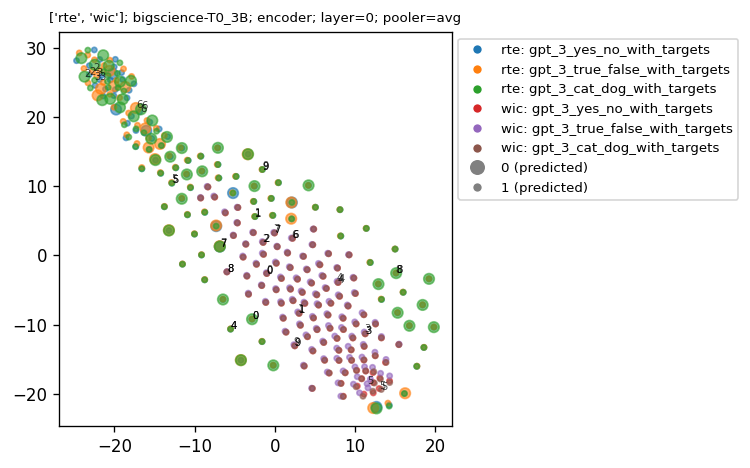

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


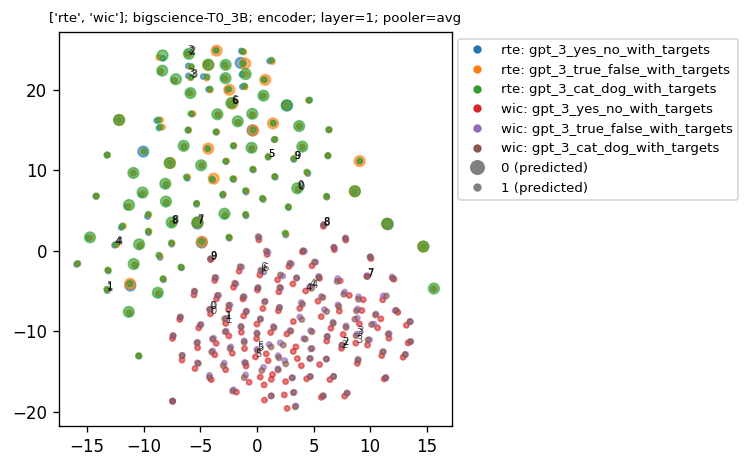

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


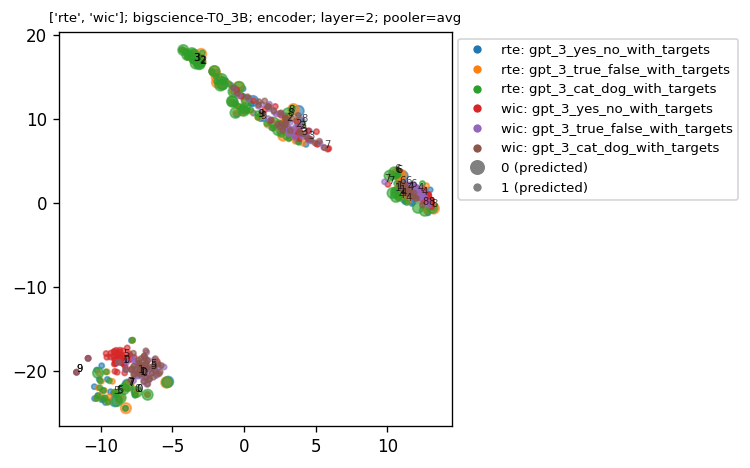

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


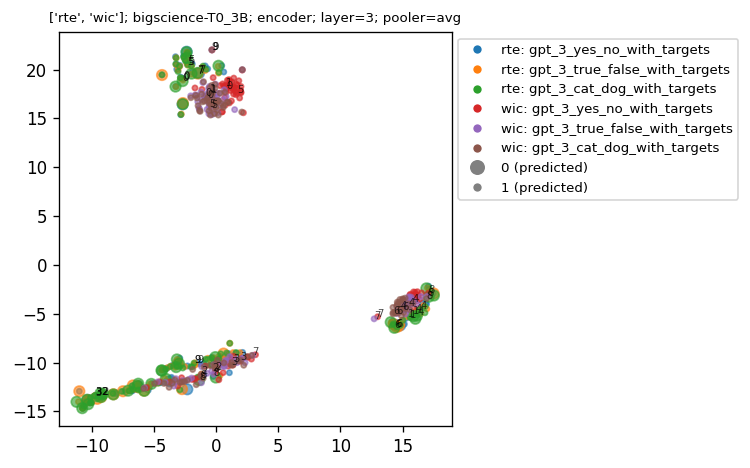

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


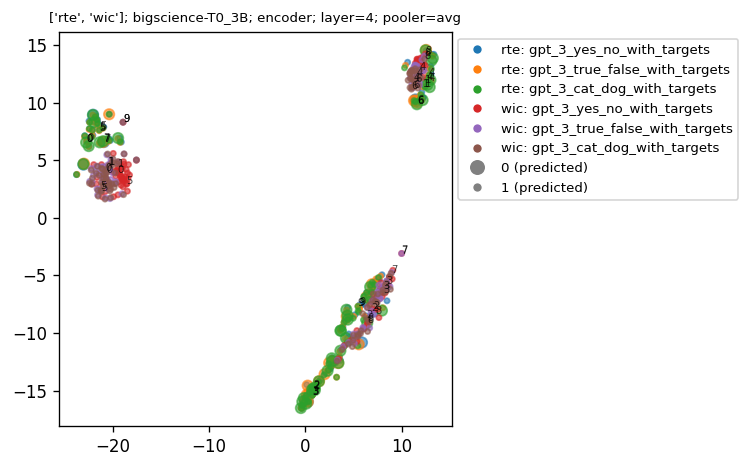

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


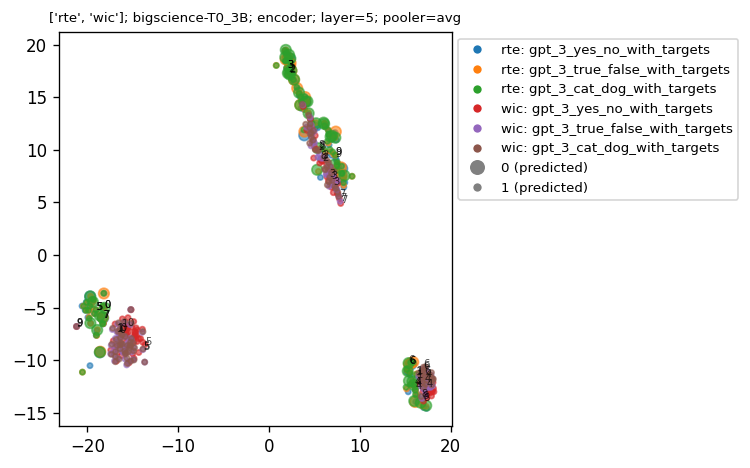

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


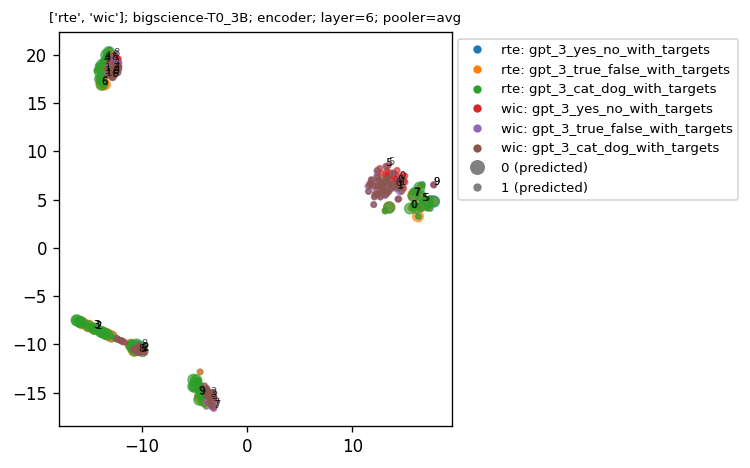

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


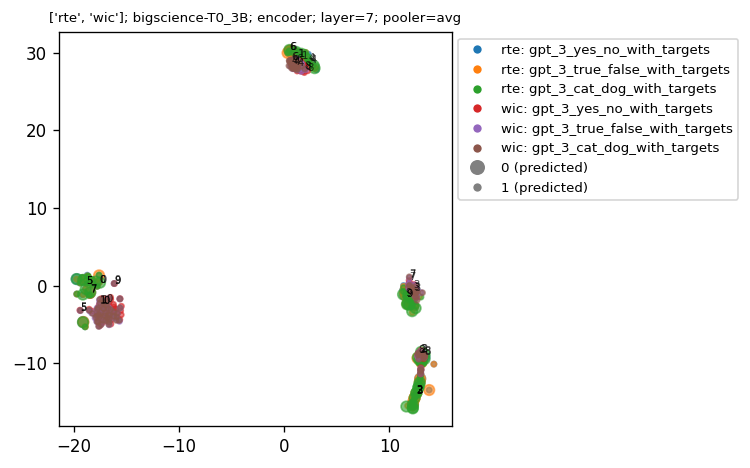

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


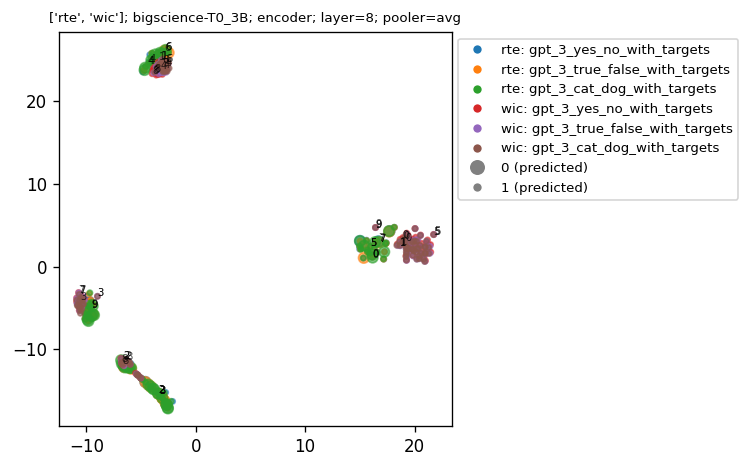

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


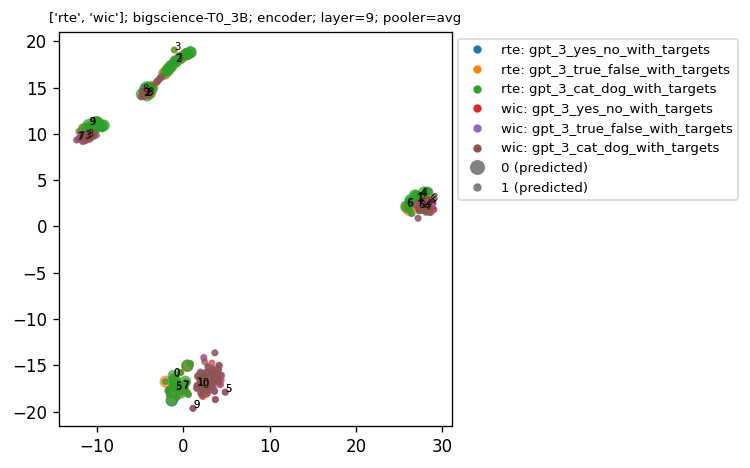

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


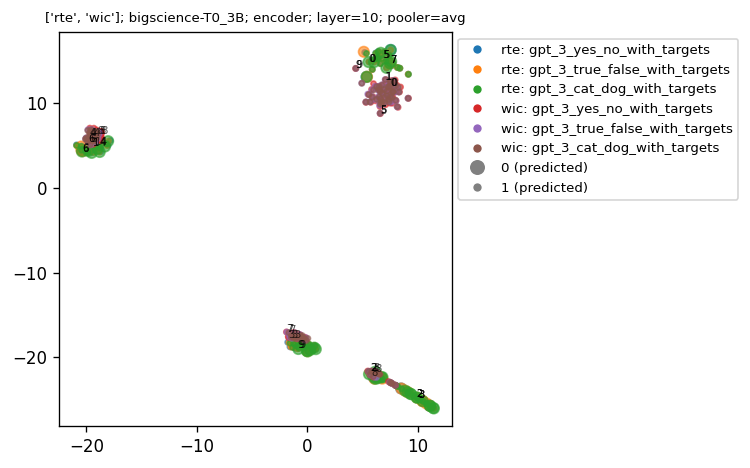

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


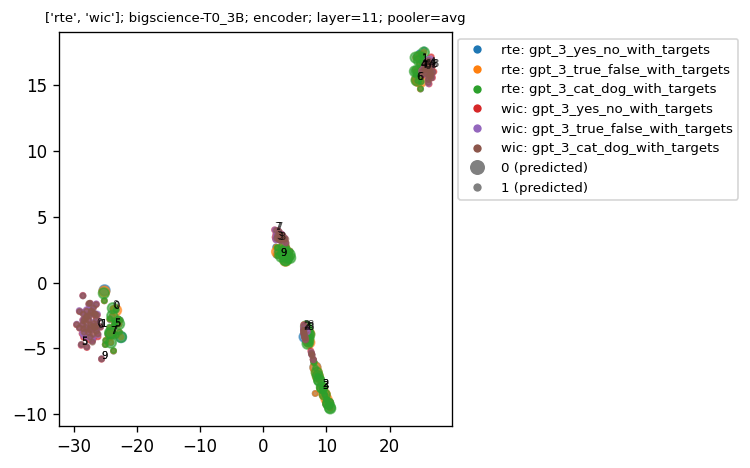

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


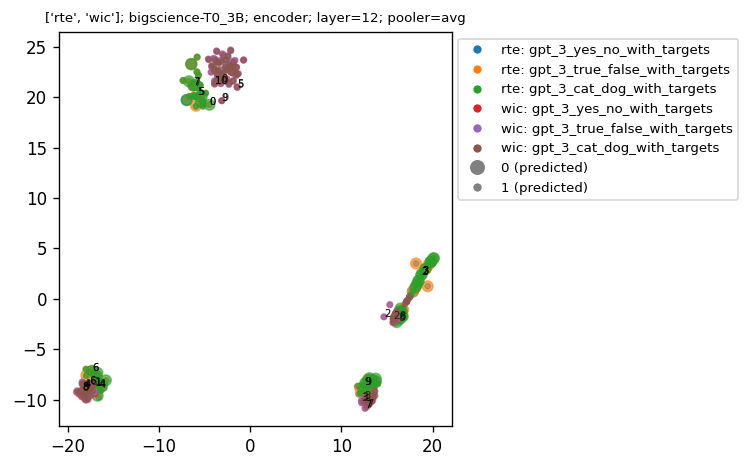

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


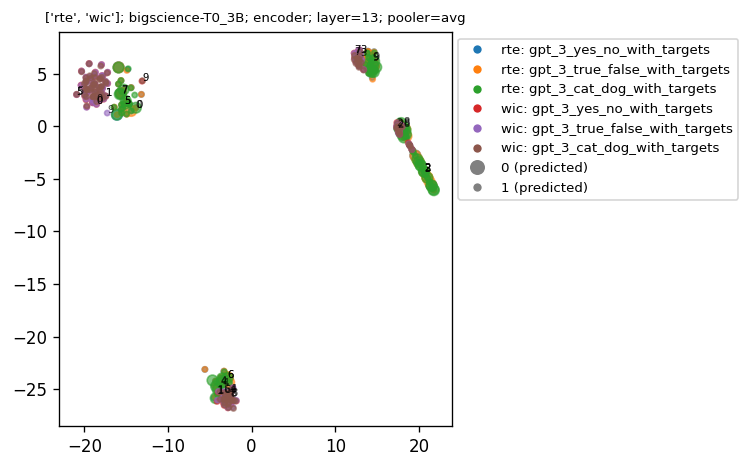

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


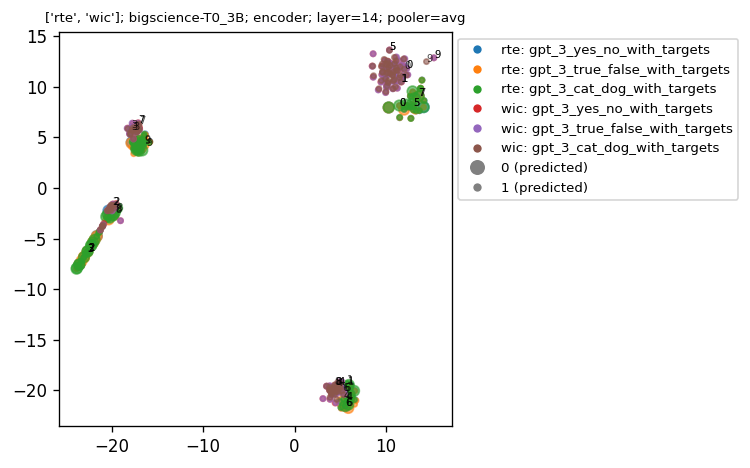

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


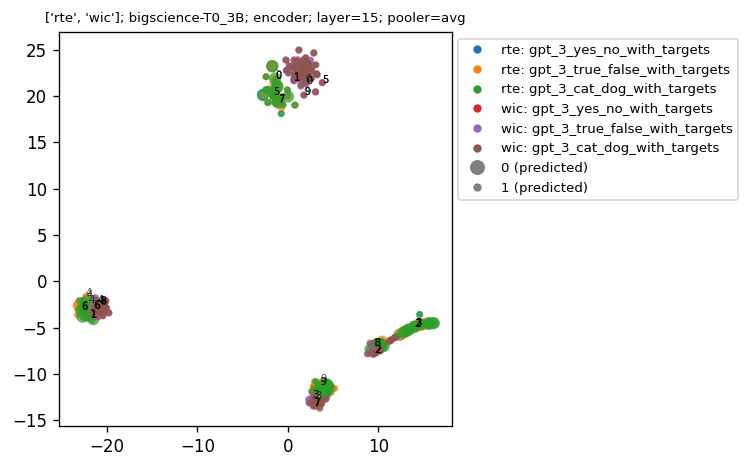

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


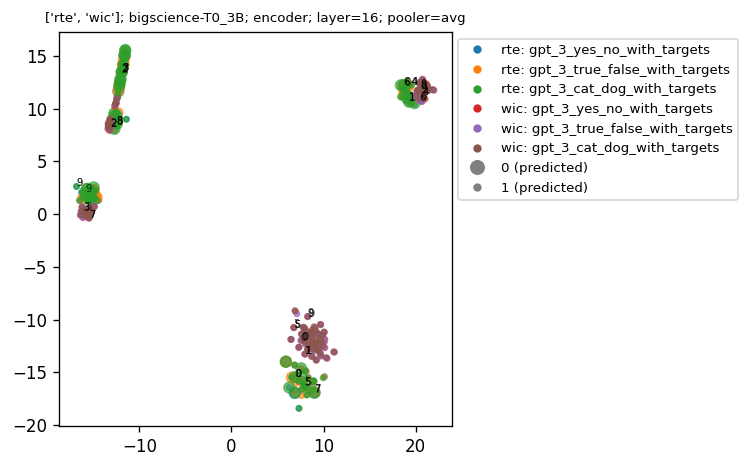

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


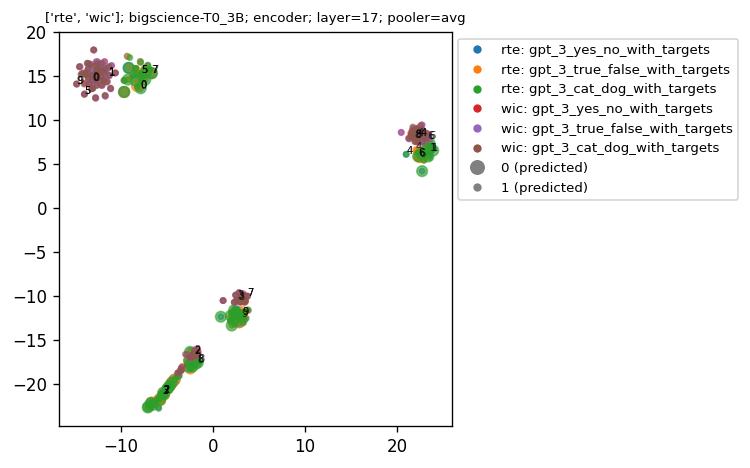

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


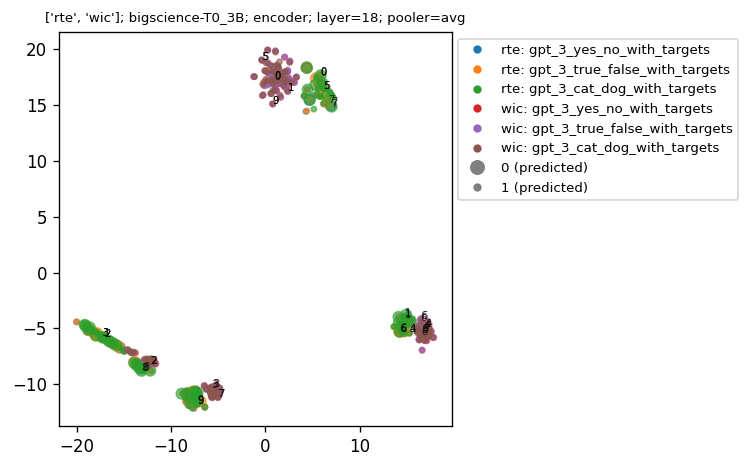

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


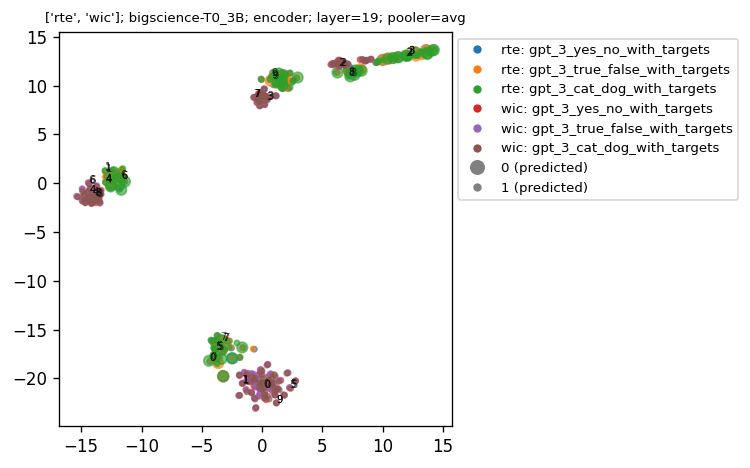

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


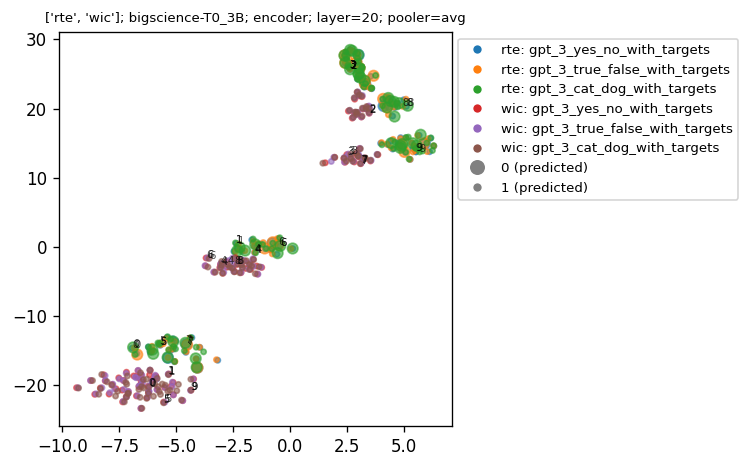

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


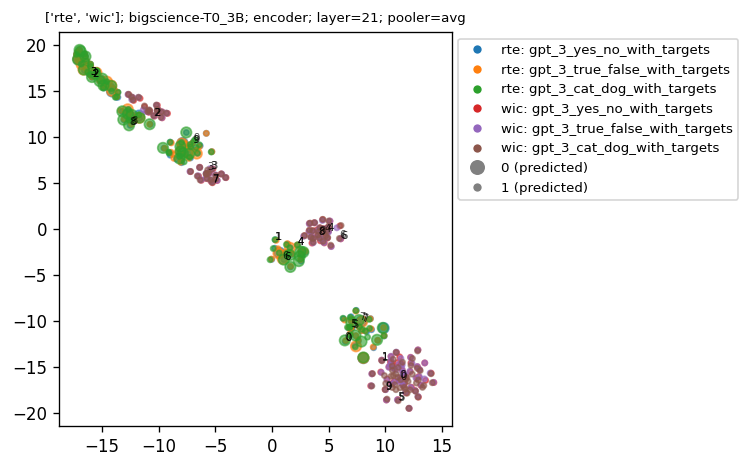

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


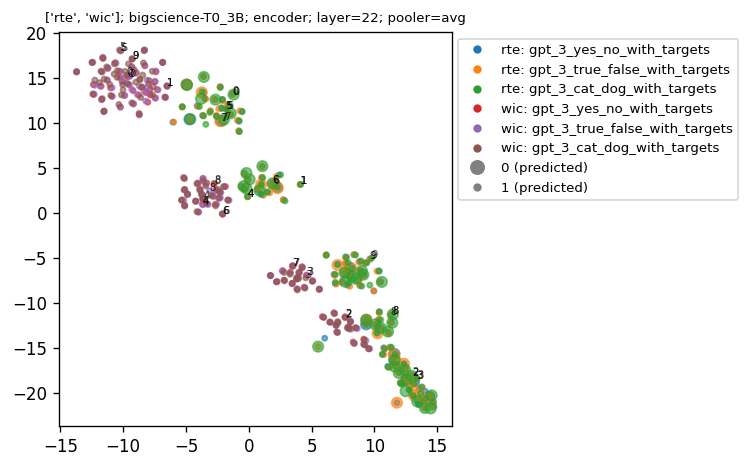

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


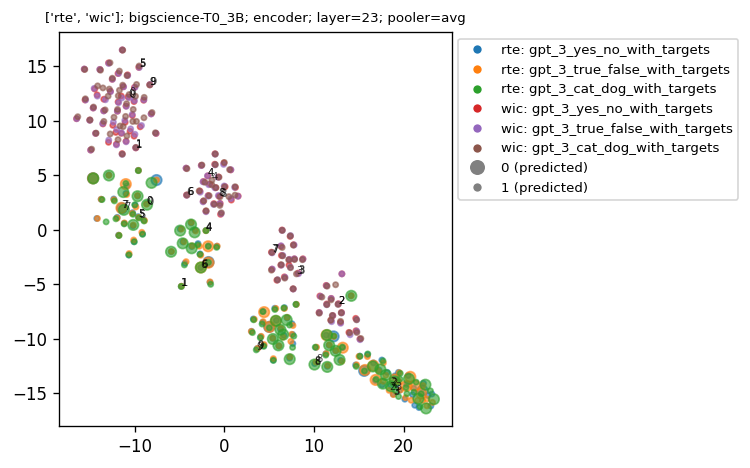

n_sequences rte: 100
(300, 2048)
n_sequences wic: 100
(300, 2048)
(600, 2048)


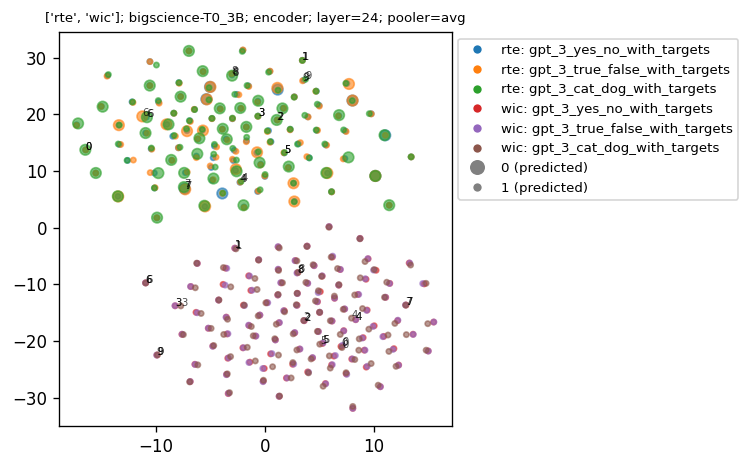

In [84]:
# for layer in range(0, 1):
# for layer in range(0, 5):
for layer in range(0, 25):
# for layer in range(24, 25):
    

    task_file_names, task_prompt_names = {task: [] for task in tasks}, {task: [] for task in tasks}
    
    for task in tasks:
        for _, row in task_dfs[task].iterrows():
            if row['name'] in use_patterns[task]:
                task_file_names[task].append(f"{task}/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5")
                task_prompt_names[task].append(row['name'])
    
    # load hidden representations from hdf5 file
    task_representations = {task: None for task in tasks}
    task_n_sequences = {task: 0 for task in tasks}

    for task in tasks:
        for file_name in task_file_names[task]:
            hidden_representations = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name), silent=True)

            # take first 100 samples only
            hidden_representations = hidden_representations[:100, :]

            task_n_sequences[task] = hidden_representations.shape[0]

            if task_representations[task] is None:
                task_representations[task] = hidden_representations
            else:
                task_representations[task] = np.concatenate((task_representations[task], hidden_representations), axis=0)

        print(f'n_sequences {task}:', task_n_sequences[task])
        print(task_representations[task].shape)

    # combine representations
    all_representations = np.concatenate([representations for _, representations in task_representations.items()])
    print(all_representations.shape)

    # compute t-SNE embeddings
    X = TSNE(
        n_components=2, 
        perplexity=100, 
        init='random', # random or pca
        learning_rate=200,
        n_iter=1000
    ).fit_transform(all_representations)

    # plot t-SNE embeddings
    fig, axes = plt.subplots(1, 1, figsize=(5.5,4), dpi=120)
    legend_elements= []

    cmap = matplotlib.cm.get_cmap('tab10')
    # cmap = matplotlib.cm.get_cmap('tab20')
    colors = cmap.colors

    idx = 0
    for _, task in enumerate(tasks):
        for jdx, file_name in enumerate(task_file_names[task]):
            # create a scatter plot for samples from each pattern and task
            x, y = X[task_n_sequences[task]*idx:task_n_sequences[task]*(idx + 1), 0], X[task_n_sequences[task]*idx:task_n_sequences[task]*(idx + 1), 1]

            # change size according to label
            if marker_size == 'ground-truth':
                # labels = input_dfs[task][task_prompt_names[task][jdx]]['label'].values
                labels = input_dfs[task][task_prompt_names[task][jdx]]['label'].values[:100]
                if task == "rte":
                    sizes = [40.0 if l == 'entailment' else 10.0 for l in labels]
                elif task == "wic":
                    sizes = [40.0 if l == 'False' else 10.0 for l in labels]
                else:
                    sizes = [10.0 for l in labels]
            elif marker_size == 'predicted':
                # labels = input_dfs[task][task_prompt_names[task][jdx]]['prediction'].values
                labels = input_dfs[task][task_prompt_names[task][jdx]]['prediction'].values[:100]
                if task == "rte":
                    sizes = [40.0 if l == 'entailment' else 10.0 for l in labels]
                elif task == "wic":
                    sizes = [40.0 if l == 'False' else 10.0 for l in labels]
                else:
                    sizes = [10.0 for l in labels]

            axes.scatter(x, y, alpha=0.6, color=colors[idx], s=sizes)
            # axes.scatter(x, y, alpha=0.6, color=colors[idx])

            # create legend element manually
            legend_elements.append(Line2D([0], [0], marker='o', color='w', label=f"{task}: {task_prompt_names[task][jdx]}", markerfacecolor=colors[idx], markersize=6))

            # annotate scatter plot with text
            samples_indices = np.random.choice(range(task_n_sequences[task]), size=20)
            # for i, txt in enumerate(list(range(task_n_sequences[task]))): # annotate all samples
            # for i, txt in enumerate(samples_indices): # annotate randomly choosen samples
            for i, txt in enumerate(range(10)): # annotate first 10 samples
                axes.annotate(txt, (x[i], y[i]), alpha=0.7, fontsize=6)

            idx += 1

    axes.set_title(f"{tasks}; {model}; {module}; layer={layer}; pooler=avg", fontsize=8)

   # Shrink current axis by 20%
    box = axes.get_position()
    axes.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    # ground-truth labels
    if marker_size == 'ground-truth':
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='gray', markersize=10))
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='gray', markersize=6))

    # predicted labels
    elif marker_size == 'predicted':
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='0 (predicted)', markerfacecolor='gray', markersize=10))
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='1 (predicted)', markerfacecolor='gray', markersize=6))
    axes.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.0, 1.0), fancybox=True, shadow=False, fontsize=8)

    plt.tight_layout()

    plt.show()
    plt.close();